# 1. Principal Components Regression

The linear combinations $Z_m$ used in principal component regression (PCR) are the principal components as defined in $\S$ 3.4.1.

PCR forms the derived input columns

$$
\mathbf{z}_m = \mathbf{X} v_m,
$$
and then regress $\mathbf{y}$ on $\mathbf{z}_1,\mathbf{z}_2,\cdots,\mathbf{z}_M$ for some $M\le p$. Since the $\mathbf{z}_m$ are orthogonal, this regression is just a sum of univariate regressions:

$$
\hat{\mathbf{y}}_{(M)}^{\text{pcr}} = \bar{y}\mathbf{1} + \sum_{m=1}^M \hat\theta_m \mathbf{z}_m = \bar{y}\mathbf{1} + \mathbf{X}\mathbf{V}_M\hat{\mathbf{\theta}},
$$
where $\hat\theta_m = \langle\mathbf{z}_m,\mathbf{y}\rangle \big/ \langle\mathbf{z}_m,\mathbf{z}_m\rangle$. We can see from the last equality that, since the $\mathbf{z}_m$ are each linear combinations of the original $\mathbf{x}_j$, we can express the solution in terms of coefficients of the $\mathbf{x}_j$.

$$
\hat\beta^{\text{pcr}}(M) = \sum_{m=1}^M \hat\theta_m v_m.
$$
As with ridge regression, PCR depends on the scaling of the inputs, so typically we first standardized them.

## Compare with Ridge:

If $M=p$, since the columns of $\mathbf{Z} = \mathbf{UD}$ span the $\text{col}(\mathbf{X})$,

$$
\hat\beta^{\text{pcr}}(p) = \hat\beta^{\text{ls}}.
$$
For $M < p$ we get a reduced regression and we see that PCR is very similar to ridge regression: both operate via the principal components of the input matrix.

- Ridge regression shrinks the coefficients of the principal components, shrinking more depending on the size of the corresponding eigenvalue;
- PCR discards the $p-M$ smallest eigenvalue components.

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("~/Statistical-Learning/data/prostate_cancer.csv")
data = data.drop('Unnamed: 0', axis = 1)

In [47]:
data_x = data.drop(['lpsa','train'], axis=1)
data_x_normalized = (data_x - data_x.mean())/data_x.std()
x_train = data_x_normalized[data.train=='T']
y_train = data[data.train=='T'].lpsa
x_train.shape

(67, 8)

In [48]:
def ridge(l, x_train, y_train):
    mat_x = x_train.values
#     mat_x = np.hstack((np.ones((len(x_train.values), 1)), x_train.values))
    mat_xt = np.transpose(mat_x)
    beta0 = np.mean(y_train)
    vec_y = y_train-beta0
    i = np.identity((mat_x.shape[1]))
    beta = np.matmul(np.linalg.inv(np.matmul(mat_xt, mat_x)+l*i), np.matmul(mat_xt, vec_y.values))
    beta = np.append(np.array([beta0]), beta)
    df = np.matrix.trace(np.matmul(mat_x, np.matmul(np.linalg.inv(np.matmul(mat_xt, mat_x)+l*i), mat_xt)))
    return beta, df

In [49]:
def lambdas_from_edf(singular_squared:np.ndarray, interval:int) ->np.ndarray:
    """Given squared singular values of data matrix, calculate the lambdas
    with `interval` parameter to split unit intervals s.t. the resulting
    effective degrees of freedom are equidistant with 1/interval, via the
    Newton-Raphson method. e.g., if interval = 10, it produces lambdas for
    0, 0.5, 0.6, 0.7, ..."""
    p = singular_squared.size
    edfs = np.linspace(.5, p-.5, (p-1)*interval+1)
    threshold = 1e-3
    lambdas = []
    for edf in edfs:
        # Newton-Raphson
        lambda0 = (p-edf)/edf
        lambda1 = 1e6
        diff = lambda1 - lambda0
        while diff > threshold:
            num = (singular_squared/(singular_squared+lambda0)).sum()-edf
            denom = (singular_squared/((singular_squared+lambda0)**2)).sum()
            lambda1 = lambda0 + num/denom
            diff = lambda1 - lambda0
            lambda0 = lambda1
        lambdas.append(lambda1)
    lambdas.append(0)
    edfs = np.concatenate((edfs, [p]))
    return edfs, np.array(lambdas)

In [50]:
import collections
import math

u, s, vh = np.linalg.svd(x_train, full_matrices=False)
s2 = s**2
edfs, lambdas = lambdas_from_edf(s2, 2)

In [51]:
edfs

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5,
       7. , 7.5, 8. ])

In [52]:
cv_l = lambdas[edfs==7][0]
cv_l

4.874490520075382

In [53]:
beta, df = ridge(cv_l, x_train, y_train)

In [54]:
df

7.000000000003947

In [55]:
beta

array([ 2.45234509,  0.58657879,  0.26065721, -0.10978358,  0.19778459,
        0.27983639, -0.16902626,  0.00820232,  0.20522034])

In [56]:
s2

array([236.41051676, 117.90586262,  71.74230521,  42.14248438,
        33.94639077,  26.63355916,  18.72563062,  12.17007033])

In [57]:
shrink_factors = s2/(s2+cv_l)
shrink_factors

array([0.97979779, 0.9602991 , 0.9363783 , 0.89632488, 0.87443638,
       0.8452938 , 0.79345485, 0.7140149 ])

In [58]:
pcr_factors = [1, 1, 1, 1, 1, 1, 1, 0]

In [59]:
import matplotlib.pyplot as plt

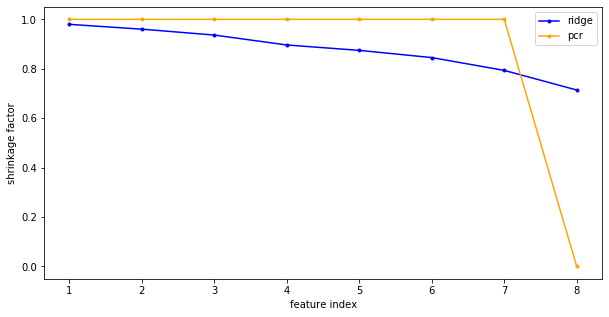

In [60]:
fig1 = plt.figure(figsize=(10,5))
fig1.clear()
ax = fig1.add_subplot(1,1,1)

ax.plot(range(1,9), shrink_factors, '.-', color='blue', label='ridge')
ax.plot(range(1,9), pcr_factors, '.-', color='orange', label='pcr')
ax.set_xlabel("feature index")
ax.set_ylabel("shrinkage factor")
ax.legend()
plt.show()

# 2. Partial Least Sqaures

Unlike PCR, partial least squares (PLS) uses $\mathbf{y}$ (in addition to $\mathbf{X}$) for the construction for a set of linear combinations of the inputs.

PLS is not scale invariant like PCR, so we assume that each $\mathbf{x}_j$ is standardized to have mean $0$ and variance $1$.

## Algorithm:

1. Standardized each $\mathbf{x}_j$ to have mean $0$ and variance $1$.
Set$$\begin{align}
\hat{\mathbf{y}}^{(0)} = \bar{y}\mathbf{1} \\
\mathbf{x}_j^{(0)} = \mathbf{x}_j, \text{ for } j=1,\cdots,p.
\end{align}$$

2. For $m = 1,2,\cdots,p$

 - $\mathbf{z}_m = \sum_{j=1}^p \hat\rho_{mj}\mathbf{x}_j^{(m-1)}$, where $\hat\rho_{mj} = \langle \mathbf{x}_j^{(m-1)},\mathbf{y}\rangle$.
 - $\hat\theta_m = \langle\mathbf{z}_m,\mathbf{y}\rangle \big/ \langle\mathbf{z}_m,\mathbf{z}_m\rangle$.
 - $\hat{\mathbf{y}}^{(m)} = \hat{\mathbf{y}}^{(m-1)} + \hat\theta_m \mathbf{z}_m$.
 - Orthogonalize each $\mathbf{x}_j^{(m-1)}$ w.r.t. $\mathbf{z}_m$: <br>
$\mathbf{x}_j^{(m)} = \mathbf{x}_j^{(m-1)} - \frac{\langle\mathbf{z}_m,\mathbf{x}_j^{(m-1)}\rangle}{\langle\mathbf{z}_m,\mathbf{y}\rangle}\mathbf{z}_m, \text{ for } j=1,2,\cdots,p$.
<br>
3. Output the sequence of fitted vectors $\left\lbrace \hat{\mathbf{y}}^{(m)}\right\rbrace_1^p$.
Since the $\left\lbrace \mathbf{z}_l \right\rbrace_1^m$ are linear in the original $\mathbf{x}_j$, so is
$$
\hat{\mathbf{y}}^{(m)} = \mathbf{X}\hat\beta^{\text{pls}}(m).
$$These linear coefficients can be recovered from the sequence of PLS transformations.

## Details:

PLS begins by computing the weights

$$
\hat\rho_{1j} = \langle \mathbf{x}_j,\mathbf{y} \rangle, \text{ for each } j,
$$
which are in fact the univariate regression coefficients, since $\mathbf{x}_j$ are standardized (only for the first step $m=1$).

From this we construct derived input

$$
\mathbf{z}_1 = \sum_j \hat\rho_{1j}\mathbf{j},
$$
which is the first PLS direction. Hence in the construction of each $\mathbf{z}_m$, the inputs are weighted by the strength of their univariate effect on $\mathbf{y}$.

The outcome $\mathbf{y}$ is regressed on $\mathbf{z}_1$ giving coefficient $\hat\theta_1$, and then we orthogonalize $\mathbf{x}_1,\cdots,\mathbf{x}_p$ w.r.t. $\mathbf{z}_1$.

We continue this process, until $M\le p$ directions have been obtained. In this manner, PLS produces a sequence of derived, orthogonal inputs or directions $\mathbf{z}_1,\cdots,\mathbf{z}_M$.

 - As with PCR, if $M=p$, then $\hat\beta^{\text{pls}} = \hat\beta^{\text{ls}}$.
 - Using $M < p$ directions produces a reduced regression.